**Trabalho 2 de Aprendizado de Máquina**

Nome: Júlio César de Paula Ferreira

Matrícula: 2020054609

# Introdução


No projeto abaixo, foi implementada uma versão do algoritmo AdaBoost para classificação usando árvores de decisão como classificadores fracos. O AdaBoost é um método de aprendizado em conjunto que combina vários classificadores fracos para criar um classificador forte. O algoritmo funciona treinando iterativamente classificadores fracos em versões e atualizando os pesos com base no desempenho desses classificadores.

Além disso, foi implementada a validação cruzada com 5 partições para avaliar o desempenho do algoritmo. Os resultados avaliaram o erro do algoritmo de acordo com o numero de classificadores utilizados.

# Implementação

Em cada iteração, o algoritmo ajusta um classificador fraco nos dados de treinamento e atualiza os pesos com base em sua classificação (correta ou incorreta).

A implementação possui a seguintes funções

num_classifiers: é o número de classificadores a serem criados e combinados no ensemble. A complexidade do modelo é alterada de acordo com o número de classificadores

max_depth: define a profundidade máxima das árvores de decisão, que são os classificadores fracos utilizados pelo AdaBoost. A profundidade está relacionada com o nível de complexidade da árvore que será utilizada, no geral o número utilizado na implementação é sempre igual a 1

classifier_weights: Lista que armazena os pesos atribuídos a cada classificador fraco. Cada peso é calculado com base na formula:


\begin{align}
peso = 0.5 \cdot \log \left( \frac{{1 - \text{erro}}}{{\text{erro}}} \right)
\end{align}



O método fit é responsável por treinar o modelo. Ele itera sobre o número de classificadores e, em cada iteração, cria um classificador fraco, com a árvore de decisão, e o ajusta aos dados de treinamento usando pesos amostrais. Em seguida, calcula o do classificador, determina o peso do classificador com base no erro e atualiza os pesos de treinamento.

O método predict é usado para fazer previsões usando o modelo treinado. Ele percorre todos os classificadores fracos e suas respectivas ponderações e faz as previsões. As previsões são então ponderadas de acordo com os pesos dos classificadores, resultando em uma previsão final.

O dataset utilizado é o tic-tac-toe, que é um conjunto de dados relacionado ao jogo da velha. Ele consiste em 958 amostras com 9 atributos representando as posições do tabuleiro (uma matriz 3x3) e um atributo de classe indicando o resultado do jogo ("positive" para vitória do jogador "x" e "negative" para vitória do jogador "o" ou empate).

Os atributos representam as posições do tabuleiro:

"x": indica que o jogador "x" marcou a posição

"o": indica que o jogador "o" marcou a posição

"b": indica uma posição vazia

Os valores de x, o e vazio foram substituídos por -1,1,0 na implementação

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
def cross_validation(X, y, model, n_folds=5):
    fold_accuracies = []

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    fold_size = len(X) // n_folds

    for i in range(n_folds):
        sidx = i * fold_size
        eidx = (i + 1) * fold_size

        validation_X = X[sidx:eidx]
        validation_y = y[sidx:eidx]

        train_X = np.concatenate((X[:sidx], X[eidx:]), axis=0)
        train_y = np.concatenate((y[:sidx], y[eidx:]), axis=0)

        model.fit(train_X, train_y)
        predictions = model.predict(validation_X)
        accuracy = np.mean(predictions == validation_y)
        fold_accuracies.append(accuracy)

    return fold_accuracies

In [3]:
class Boosting:
    def __init__(self, num_classifiers=5, max_depth=1):
        self.num_classifiers = num_classifiers
        self.max_depth = max_depth
        self.classifiers = []
        self.classifier_weights = []

    def fit(self, X, y):
        weights = np.ones(X.shape[0]) / X.shape[0]

        for i in range(self.num_classifiers):
            clf = DecisionTreeClassifier(max_depth=self.max_depth)

            clf.fit(X, y, sample_weight=weights)

            y_pred = clf.predict(X)
            error = np.dot(weights, y_pred != y)

            weight = 0.5 * np.log((1 - error) / error)

            weights = np.multiply(weights, np.exp(-weight * y * y_pred))
            weights = np.divide(weights, np.sum(weights))

            self.classifiers.append(clf)
            self.classifier_weights.append(weight)

    def predict(self, X):
        results = np.zeros(X.shape[0])

        for i in range(len(self.classifiers)):
            y_pred = self.classifiers[i].predict(X)

            results += self.classifier_weights[i] * y_pred

        labels = np.sign(results)

        return labels


url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data'
df = pd.read_csv(url, header=None)
df.replace({'x': -1, 'o': 1, 'b': 0, 'positive': 1, 'negative': -1}, inplace=True)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [4]:
#Run model
num_classifiers = 500
max_depth = 1
mean_accuracies = []
mean_errors = []
true_positive_rates = []
false_positive_rates = []

for n in range(1, num_classifiers + 1):
    boost = Boosting(num_classifiers=n, max_depth=max_depth)
    fold_accuracies = cross_validation(X, y, boost, n_folds=5)
    mean_accuracy = np.mean(fold_accuracies)
    mean_accuracies.append(mean_accuracy)
    mean_errors.append(1 - mean_accuracy)

    predictions = boost.predict(X)

    cm = confusion_matrix(y, predictions)

    tp = cm[1, 1]
    fp = cm[0, 1]
    tn = cm[0, 0]
    fn = cm[1, 0]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)

# Resultados

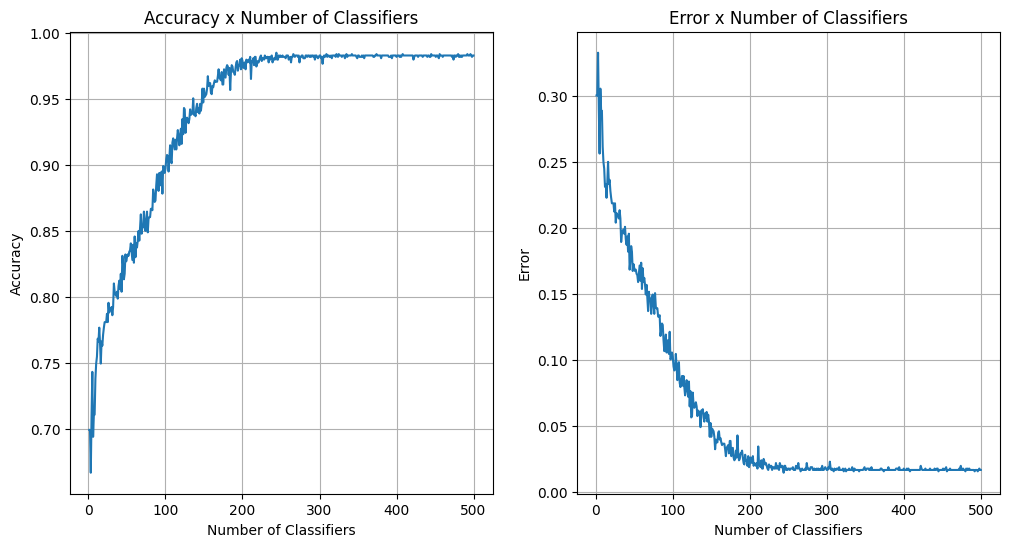

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_classifiers + 1), mean_accuracies)
ax1.set_title('Accuracy x Number of Classifiers')
ax1.set_xlabel('Number of Classifiers')
ax1.set_ylabel('Accuracy')
ax1.grid(True)

ax2.plot(range(1, num_classifiers + 1), mean_errors)
ax2.set_title('Error x Number of Classifiers')
ax2.set_xlabel('Number of Classifiers')
ax2.set_ylabel('Error')
ax2.grid(True)

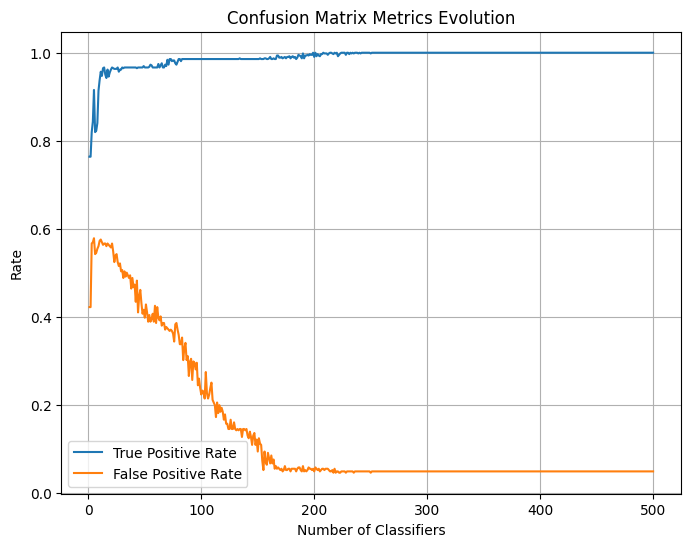

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_classifiers + 1), true_positive_rates, label='True Positive Rate')
plt.plot(range(1, num_classifiers + 1), false_positive_rates, label='False Positive Rate')
plt.title('Confusion Matrix Metrics Evolution')
plt.xlabel('Number of Classifiers')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

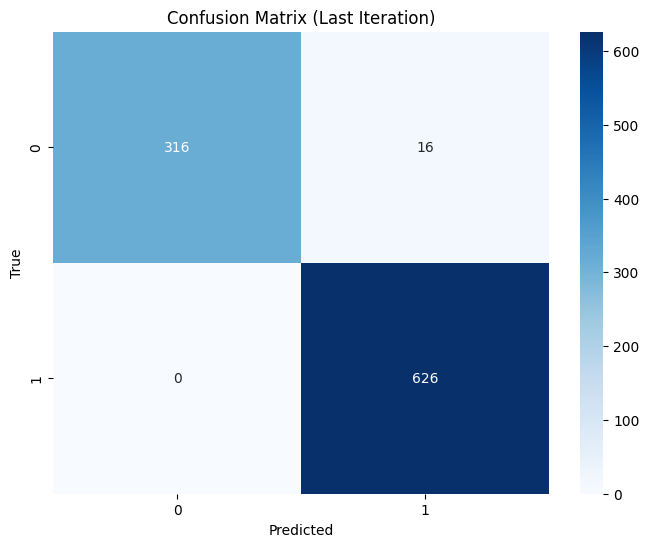

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix (Last Iteration)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()